# Introduction

In this kernel, we are going to predict whether a credit card is fraud or not using Machine Learning.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Due to confidentiality issues, the input variables are transformed into numerical using PCA transformations.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importing the required Python libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
sns.set()
warnings.simplefilter('ignore')

# Data Preprocessing

In [ ]:
data = pd.read_csv('/content/drive/My Drive/IT352 IAS/IAS_Project/creditcard.csv')
df = data.copy() # To keep the data as backup
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.shape

(284807, 31)

In [ ]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [ ]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [ ]:
df.Time.tail(15)

284792    172774.0
284793    172775.0
284794    172777.0
284795    172778.0
284796    172780.0
284797    172782.0
284798    172782.0
284799    172783.0
284800    172784.0
284801    172785.0
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, dtype: float64

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## Checking the frequency of frauds before moving forward

In [ ]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

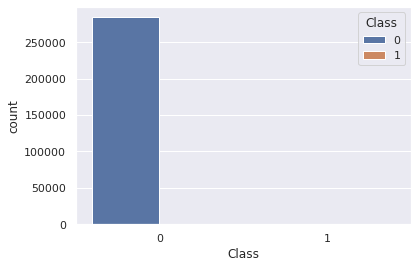

In [ ]:
sns.countplot(x=df.Class, hue=df.Class)

By looking at the above statistics, we can see that the data is highly imbalanced. Only 492 out of 284807 are fraud.

## Checking the distribution of amount

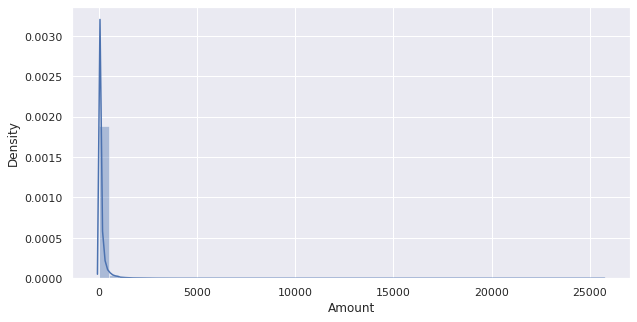

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(df.Amount)

Since, it is a little difficult to see. Let's engineer a new feature of bins.

In [ ]:
df['Amount-Bins'] = ''

Now, let's set the bins and their labels.

In [ ]:
def make_bins(predictor, size=50):
    '''
    Takes the predictor (a series or a dataframe of single predictor) and size of bins
    Returns bins and bin labels
    '''
    bins = np.linspace(predictor.min(), predictor.max(), num=size)

    bin_labels = []

    # Index of the final element in bins list
    bins_last_index = bins.shape[0] - 1

    for id, val in enumerate(bins):
        if id == bins_last_index:
            continue
        val_to_put = str(int(bins[id])) + ' to ' + str(int(bins[id + 1]))
        bin_labels.append(val_to_put)
    
    return bins, bin_labels

In [ ]:
bins, bin_labels = make_bins(df.Amount, size=10)

Now, adding bins in the column Amount-Bins.

In [ ]:
df['Amount-Bins'] = pd.cut(df.Amount, bins=bins,
                           labels=bin_labels, include_lowest=True)
df['Amount-Bins'].head().to_frame()

,Amount-Bins
0,0 to 2854
1,0 to 2854
2,0 to 2854
3,0 to 2854
4,0 to 2854


Let's plot the bins.

In [ ]:
df['Amount-Bins'].value_counts()

0 to 2854         284484
2854 to 5709         285
5709 to 8563          28
8563 to 11418          4
11418 to 14272         3
17127 to 19982         2
22836 to 25691         1
19982 to 22836         0
14272 to 17127         0
Name: Amount-Bins, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

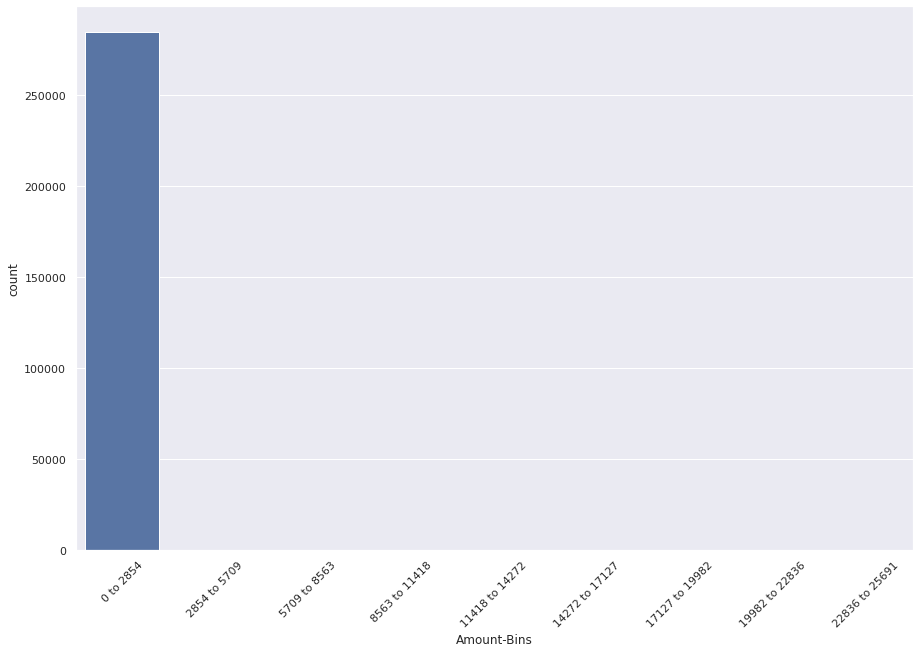

In [ ]:
plt.figure(figsize=(15, 10))
sns.countplot(x='Amount-Bins', data=df)
plt.xticks(rotation=45)

Since, count of values of Bins other than '0 to 2854' are difficult to view. Let's not insert the first one.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

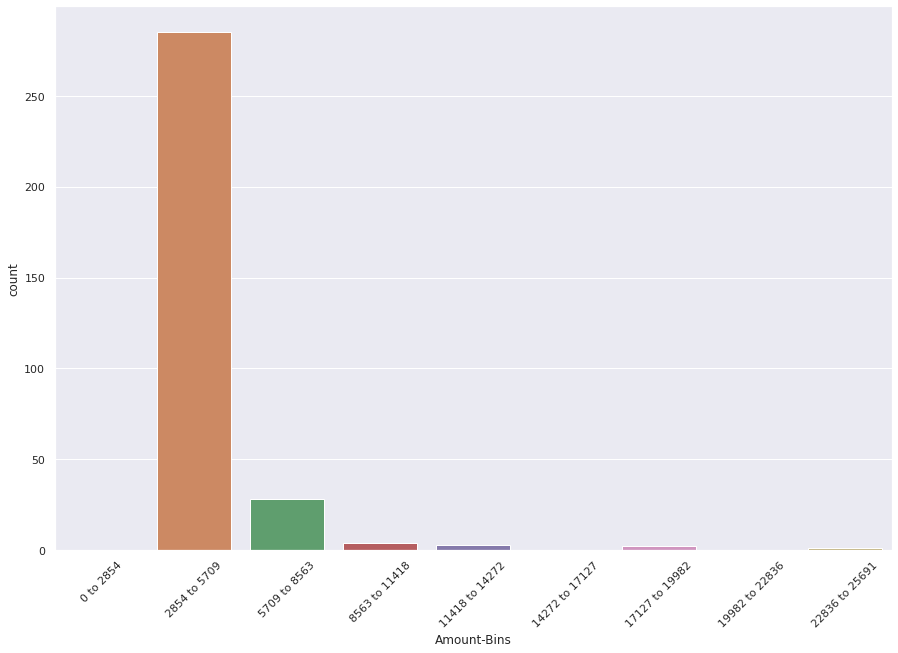

In [ ]:
plt.figure(figsize=(15, 10))
sns.countplot(x='Amount-Bins', data=df[~(df['Amount-Bins'] == '0 to 2854')])
plt.xticks(rotation=45)

We can see that mostly the amount is between 0 and 2854 euros. 

# Predictive Modelling

Let's predict whether a credit card is fraud or not using machine learning.

## One-hot encoding the Amount-Bins

Since, for classification, we need to pass the data in numerical form. That's why we need to One-Hot encode the Amount-Bins column.<br>
```Note: We can also label encode values.```

In [ ]:
df_encoded = pd.get_dummies(data=df, columns=['Amount-Bins'])
df = df_encoded.copy()

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Amount-Bins_0 to 2854,Amount-Bins_2854 to 5709,Amount-Bins_5709 to 8563,Amount-Bins_8563 to 11418,Amount-Bins_11418 to 14272,Amount-Bins_14272 to 17127,Amount-Bins_17127 to 19982,Amount-Bins_19982 to 22836,Amount-Bins_22836 to 25691
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1,0,0,0,0,0,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1,0,0,0,0,0,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1,0,0,0,0,0,0,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1,0,0,0,0,0,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1,0,0,0,0,0,0,0,0


## Breaking the dataset into training and testing

First, separating the response variable from the explanatory variables.

In [ ]:
X = df.drop(labels='Class', axis=1)
Y = df['Class']

X.shape, Y.shape

((284807, 39), (284807,))

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(
    X, Y, random_state=42, test_size=0.3, shuffle=True)

print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(199364, 39) (199364,)
(85443, 39) (85443,)


## Applying Machine Learning Algorithms

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()

In [ ]:
# Training the algorithm
lr_model.fit(xtrain, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# Predictions on training and testing data
lr_pred_train = lr_model.predict(xtrain)
lr_pred_test = lr_model.predict(xtest)

Before going further into metrics, let's first decide either Type-I or Type-II error is more important to consider.<br><br>
```Type-I  Error or False Positives:``` False Positives are the ones which are actually not fraud but the prediction said that they are fraud.<br>
```Type-II Error or False Negatives:``` False Negatives are the ones which are actually fraud but the system said that they aren't.

Well, we can say that Type-II Error is more significant because we don't want system to have a fraudulent credit card because that can be more dangerous.

So, for Type-II Error, We can say that **recall** is the important metric.

In [ ]:
# Importing the required metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

**confusion matrix**.

In [ ]:
tn, fp, fn, tp = confusion_matrix(ytest, lr_pred_test).ravel()
conf_matrix = pd.DataFrame(
    {
        'Predicted Fraud': [tp, fp],
        'Predicted Not Fraud': [fn, tn]
    }, index=['Fraud', 'Not Fraud'])
conf_matrix

,Predicted Fraud,Predicted Not Fraud
Fraud,81,55
Not Fraud,23,85284


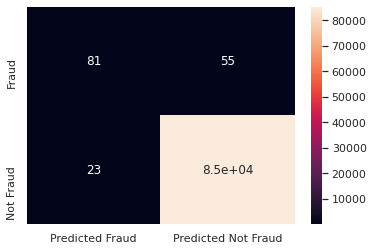

In [ ]:
sns.heatmap(conf_matrix, annot=True)

Heatmap also suggests that the data is highly imbalanced.

Accuracy score.

In [ ]:
lr_accuracy = accuracy_score(ytest, lr_pred_test)
lr_precision = precision_score(ytest, lr_pred_test)
lr_recall = recall_score(ytest, lr_pred_test)
lr_f1 = f1_score(ytest, lr_pred_test)
print("Accuracy:", + lr_accuracy)
print("Precision:", + lr_precision)
print("Recall:", + lr_recall)
print("f1_score:", + lr_f1)

Accuracy: 0.9990871107053826
Precision: 0.7788461538461539
Recall: 0.5955882352941176
f1_score: 0.675


We can see here that accuracy is great around 99%.<br>

We know that the dataset is highly unbalanced and accuracy takes into account the whole confusion matrix.

#### Model Complexity

Logistic Regression models on the 2nd degree of polynomials. Not going further 2nd degree because features are already too much. Otherwise, computer gives the MemoryError.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
# Getting the polynomial features
poly = PolynomialFeatures(degree=2)
xtrain_poly = poly.fit_transform(xtrain)
xtest_poly = poly.fit_transform(xtest)

# Training the model
model = LogisticRegression()
model.fit(xtrain_poly, ytrain)

# Getting the probabilities
train_prob = model.predict_proba(xtrain_poly)[:, 1]
test_prob = model.predict_proba(xtest_poly)[:, 1]

(0.9122902475491923, 0.9238498202685249)

Recall in case of model complexity.

In [ ]:
mlr_accuracy = accuracy_score(ytest, model.predict(xtest_poly))
mlr_precision = precision_score(ytest, model.predict(xtest_poly))
mlr_recall = recall_score(ytest, model.predict(xtest_poly))
mlr_f1 = f1_score(ytest, model.predict(xtest_poly))
print("Accuracy:", + mlr_accuracy)
print("Precision:", + mlr_precision)
print("Recall:", + mlr_recall)
print("f1_score:", + mlr_f1)

Accuracy: 0.9985955549313578
Precision: 0.5425531914893617
Recall: 0.75
f1_score: 0.6296296296296297


Recall has increased when the model is made complex.

### Support Vector Machine

For support vector machines, we need to train the model after scaling the features.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mms = MinMaxScaler()
mms

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Amount-Bins_0 to 2854,Amount-Bins_2854 to 5709,Amount-Bins_5709 to 8563,Amount-Bins_8563 to 11418,Amount-Bins_11418 to 14272,Amount-Bins_14272 to 17127,Amount-Bins_17127 to 19982,Amount-Bins_19982 to 22836,Amount-Bins_22836 to 25691
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,1,0,0,0,0,0,0,0,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,1,0,0,0,0,0,0,0,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,1,0,0,0,0,0,0,0,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,1,0,0,0,0,0,0,0,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,1,0,0,0,0,0,0,0,0


In [ ]:
X_scaled = mms.fit_transform(X)

In [ ]:
X_scaled = pd.DataFrame(data=X_scaled, columns=X.columns)
X_scaled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Amount-Bins_0 to 2854,Amount-Bins_2854 to 5709,Amount-Bins_5709 to 8563,Amount-Bins_8563 to 11418,Amount-Bins_11418 to 14272,Amount-Bins_14272 to 17127,Amount-Bins_17127 to 19982,Amount-Bins_19982 to 22836,Amount-Bins_22836 to 25691
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, let's train test split on the scaled data.

In [ ]:
xtrainS, xtestS, ytrainS, ytestS = train_test_split(
    X_scaled, Y, random_state=42, test_size=0.30, shuffle=True)

In [ ]:
print(xtrainS.shape, ytrainS.shape)
print(xtestS.shape, ytestS.shape)

(199364, 39) (199364,)
(85443, 39) (85443,)


In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_model = SVC(kernel='linear', probability=True)

In [ ]:
svc_model.fit(xtrainS, ytrainS)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
svc_pred = svc_model.predict(xtestS)

In [ ]:
svm_accuracy = accuracy_score(ytestS, svc_pred)
svm_precision = precision_score(ytestS, svc_pred)
svm_recall = recall_score(ytestS, svc_pred)
svm_f1 = f1_score(ytestS, svc_pred)
print("Accuracy:", + svm_accuracy)
print("Precision:", + svm_precision)
print("Recall:", + svm_recall)
print("f1_score:", + svm_f1)

Accuracy: 0.9994265182636377
Precision: 0.8320610687022901
Recall: 0.8014705882352942
f1_score: 0.8164794007490637


Recall quite increased in case of SVC.

### Naive Bayes Algorithm

Naive Bayes Machine Learning Algorithm.

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nb = GaussianNB()

In [ ]:
nb.fit(xtrain, ytrain)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
nb_pred = nb.predict(xtest)
nb_pred_proba = nb.predict_proba(xtest)[:, 1]

In [ ]:
accuracy_score(ytest, nb_pred)
nb_accuracy = accuracy_score(ytestS, nb_pred)
nb_precision = precision_score(ytestS, nb_pred)
nb_recall = recall_score(ytestS, nb_pred)
nb_f1 = f1_score(ytestS, nb_pred)
print("Accuracy:", + nb_accuracy)
print("Precision:", + nb_precision)
print("Recall:", + nb_recall)
print("f1_score:", + nb_f1)

Accuracy: 0.9930479969102208
Precision: 0.14106583072100312
Recall: 0.6617647058823529
f1_score: 0.2325581395348837


Conclusion: Naive Bayes didn't perform well as compared to the other ones.